<a href="https://githubtocolab.com/giswqs/geemap/blob/master/examples/notebooks/35_geemap_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# **Connect Github**

In [1]:
!git clone https://github.com/MuffinCrunchy/air-pollution-forecasting.git

Cloning into 'air-pollution-forecasting'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (380/380), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 380 (delta 108), reused 297 (delta 64), pack-reused 0
Receiving objects: 100% (380/380), 1.43 MiB | 5.33 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
ls

air-pollution-forecasting/  sample_data/


# **Library**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import math
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# **1 Year**

## **Read Datasets**

In [4]:
df = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2020.csv')
df['tanggal'] = pd.to_datetime(df.tanggal)
df['tanggal'] = df['tanggal'].dt.strftime('%Y-%m-%d')
df

,tanggal,pm10,so2,co,o3,no2
0,2020-01-01,33.0,36.0,6.4,36.0,6.0
1,2020-01-02,45.0,36.0,25.0,46.0,5.0
2,2020-01-03,51.0,37.0,15.0,46.0,6.0
3,2020-01-04,48.0,38.0,14.0,51.0,5.0
4,2020-01-05,40.0,39.0,19.0,50.0,5.0
...,...,...,...,...,...,...
361,2020-12-27,30.0,35.0,10.0,44.0,4.0
362,2020-12-28,29.0,34.0,9.0,31.0,3.0
363,2020-12-29,21.0,34.0,5.0,20.0,2.0
364,2020-12-30,26.0,34.0,6.0,15.0,3.0


In [5]:
df_test = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2021.csv')
df_test['tanggal'] = pd.to_datetime(df_test.tanggal)
df_test['tanggal'] = df_test['tanggal'].dt.strftime('%Y-%m-%d')
df_test

,tanggal,pm10,so2,co,o3,no2
0,2021-01-01,41.0,37.0,14.0,35.0,4.0
1,2021-01-02,44.0,38.0,38.0,59.0,3.0
2,2021-01-03,50.0,37.0,16.0,52.0,5.0
3,2021-01-04,45.0,36.0,16.0,24.0,3.0
4,2021-01-05,52.0,36.0,15.0,35.0,8.0
...,...,...,...,...,...,...
360,2021-12-27,68.0,17.0,21.0,67.4,12.0
361,2021-12-28,59.0,38.0,15.0,24.8,22.0
362,2021-12-29,61.0,37.0,15.0,38.6,19.0
363,2021-12-30,60.0,38.0,17.0,24.2,21.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  366 non-null    object 
 1   pm10     366 non-null    float64
 2   so2      366 non-null    float64
 3   co       366 non-null    float64
 4   o3       366 non-null    float64
 5   no2      366 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.3+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  365 non-null    object 
 1   pm10     365 non-null    float64
 2   so2      365 non-null    float64
 3   co       365 non-null    float64
 4   o3       365 non-null    float64
 5   no2      365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


In [8]:
# df_train.set_index('tanggal', inplace=True, drop=True)
# df_train.head()

In [9]:
# df_test.set_index('tanggal', inplace=True, drop=True)
# df_test.head()

## **Train Test Split**

In [10]:
size = 334 # Take 1 month for validation

df_train = df[:size]
df_valid = df[size:]

In [11]:
df_train

,tanggal,pm10,so2,co,o3,no2
0,2020-01-01,33.0,36.0,6.4,36.0,6.0
1,2020-01-02,45.0,36.0,25.0,46.0,5.0
2,2020-01-03,51.0,37.0,15.0,46.0,6.0
3,2020-01-04,48.0,38.0,14.0,51.0,5.0
4,2020-01-05,40.0,39.0,19.0,50.0,5.0
...,...,...,...,...,...,...
329,2020-11-25,60.0,42.0,23.0,93.0,7.0
330,2020-11-26,47.0,43.0,8.0,78.0,7.0
331,2020-11-27,50.0,41.0,16.0,73.0,11.0
332,2020-11-28,46.0,40.0,9.0,58.0,5.0


In [12]:
df_valid.head()

,tanggal,pm10,so2,co,o3,no2
334,2020-11-30,29.0,40.0,13.0,20.0,4.0
335,2020-12-01,38.0,40.0,10.0,41.0,6.0
336,2020-12-02,31.0,41.0,10.0,47.0,6.0
337,2020-12-03,40.0,45.0,10.0,54.0,7.0
338,2020-12-04,28.0,42.0,7.0,23.0,3.0


### **Data Training**

In [13]:
date_train = df_train[['tanggal']]
date_train

,tanggal
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
329,2020-11-25
330,2020-11-26
331,2020-11-27
332,2020-11-28


In [14]:
data_train = df_train[['co']]
data_train

,co
0,6.4
1,25.0
2,15.0
3,14.0
4,19.0
...,...
329,23.0
330,8.0
331,16.0
332,9.0


In [15]:
data_train.shape

(334, 1)

### **Data Validation**

In [16]:
date_valid = df_valid[['tanggal']]
date_valid.head()

,tanggal
334,2020-11-30
335,2020-12-01
336,2020-12-02
337,2020-12-03
338,2020-12-04


In [17]:
data_valid = df_valid[['co']]
data_train

,co
0,6.4
1,25.0
2,15.0
3,14.0
4,19.0
...,...
329,23.0
330,8.0
331,16.0
332,9.0


In [18]:
data_valid.shape

(32, 1)

### **Data Testing**

In [19]:
date_test = df_test[['tanggal']]
date_test.head()

,tanggal
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [20]:
data_test = df_test[['co']]
data_test.head()

,co
0,14.0
1,38.0
2,16.0
3,16.0
4,15.0


In [21]:
data_test.shape

(365, 1)

## **Normalize Data**

In [22]:
minmax = MinMaxScaler(feature_range=(0, 1))
data_train = minmax.fit_transform(data_train)
data_valid = minmax.fit_transform(data_valid)
data_test = minmax.fit_transform(data_test)

## **Input Parameter**

In [23]:
look_back = 1

train_gen = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=7)
valid_gen = TimeseriesGenerator(data_valid, data_valid, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

In [24]:
print('Samples: {}'.format(len(train_gen)))

Samples: 48


In [25]:
for i in range(len(train_gen)):
	x, y = train_gen[i]
	print('{} => {}'.format(x, y))

[[[0.02330097]]

 [[0.2038835 ]]

 [[0.10679612]]

 [[0.09708738]]

 [[0.14563107]]

 [[0.2815534 ]]

 [[0.13592233]]] => [[0.2038835 ]
 [0.10679612]
 [0.09708738]
 [0.14563107]
 [0.2815534 ]
 [0.13592233]
 [0.11650485]]
[[[0.11650485]]

 [[0.26213592]]

 [[0.13592233]]

 [[0.11650485]]

 [[0.15533981]]

 [[0.04854369]]

 [[0.06796117]]] => [[0.26213592]
 [0.13592233]
 [0.11650485]
 [0.15533981]
 [0.04854369]
 [0.06796117]
 [0.06796117]]
[[[0.06796117]]

 [[0.05825243]]

 [[0.32038835]]

 [[0.31067961]]

 [[0.10679612]]

 [[0.65048544]]

 [[0.08737864]]] => [[0.05825243]
 [0.32038835]
 [0.31067961]
 [0.10679612]
 [0.65048544]
 [0.08737864]
 [0.12621359]]
[[[0.12621359]]

 [[0.2038835 ]]

 [[0.15533981]]

 [[0.17475728]]

 [[0.21359223]]

 [[0.24271845]]

 [[0.08737864]]] => [[0.2038835 ]
 [0.15533981]
 [0.17475728]
 [0.21359223]
 [0.24271845]
 [0.08737864]
 [0.31067961]]
[[[0.31067961]]

 [[0.22330097]]

 [[0.09708738]]

 [[0.13592233]]

 [[0.09708738]]

 [[0.11650485]]

 [[0.34951456]

In [26]:
print('Samples: {}'.format(len(valid_gen)))

Samples: 31


In [27]:
for i in range(len(valid_gen)):
	x, y = valid_gen[i]
	print('{} => {}'.format(x, y))

[[[0.61538462]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.15384615]]
[[[0.15384615]]] => [[0.30769231]]
[[[0.30769231]]] => [[0.23076923]]
[[[0.23076923]]] => [[0.61538462]]
[[[0.61538462]]] => [[0.07692308]]
[[[0.07692308]]] => [[0.07692308]]
[[[0.07692308]]] => [[0.07692308]]
[[[0.07692308]]] => [[0.53846154]]
[[[0.53846154]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.07692308]]
[[[0.07692308]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.46153846]]
[[[0.46153846]]] => [[0.23076923]]
[[[0.23076923]]] => [[0.30769231]]
[[[0.30769231]]] => [[0.]]
[[[0.]]] => [[0.15384615]]
[[[0.15384615]]] => [[0.30769231]]
[[[0.30769231]]] => [[0.07692308]]
[[[0.07692308]]] => [[0.38461538]]
[[[0.38461538]]] => [[1.]]
[[[1.]]] => [[0.46153846]]
[[[0.46153846]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.15384615]]
[[[0.15384615]]] => [[0.38461538]]
[[[0.38461538]]] => [[0.30769231]]
[[[0.30769231]]] => [[0.]]
[[[0.]]] => [[0.07692308]

In [28]:
print('Samples: {}'.format(len(test_gen)))

Samples: 364


In [29]:
for i in range(len(test_gen)):
	x, y = test_gen[i]
	print('{} => {}'.format(x, y))

[[[0.25]]] => [[0.79545455]]
[[[0.79545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.27272727]]
[[[0.27272727]]] => [[0.59090909]]
[[[0.59090909]]] => [[0.36363636]]
[[[0.36363636]]] => [[0.45454545]]
[[[0.45454545]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.31818182]]
[[[0.31818182]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.11363636]]
[[[0.11363636]]] => [[0.22727273]]
[[[0.22727273]]] => [[0.38636364]]
[[[0.38636364]]] => [[0.34090909]]
[[[0.34090909]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.15909091]]
[[[0.15909091]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.40909091]]
[[[0.40909091]]] => [[0.65909091]]
[[[0.65909091]]] => [[1.]]
[[[1.]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.09090909]]
[[[0.09090909]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.29545455]]
[[[0.295454

In [30]:
# test_gen_date = date_test[look_back:]
# test_gen_date = test_gen_date.to_numpy()
# test_gen_date =

# [dt.datetime.strptime(dates,'%m/%d/%Y').date() for dates in test_gen_date]

In [31]:
test_gen_value = data_test[look_back:]
test_gen_value

array([[0.79545455],
       [0.29545455],
       [0.29545455],
       [0.27272727],
       [0.59090909],
       [0.36363636],
       [0.45454545],
       [0.70454545],
       [0.13636364],
       [0.31818182],
       [0.18181818],
       [0.11363636],
       [0.22727273],
       [0.38636364],
       [0.34090909],
       [0.20454545],
       [0.15909091],
       [0.20454545],
       [0.29545455],
       [0.40909091],
       [0.65909091],
       [1.        ],
       [0.3370365 ],
       [0.3370365 ],
       [0.70454545],
       [0.09090909],
       [0.18181818],
       [0.13636364],
       [0.29545455],
       [0.31818182],
       [0.3370365 ],
       [0.25      ],
       [0.13636364],
       [0.20454545],
       [0.20454545],
       [0.09090909],
       [0.15909091],
       [0.15909091],
       [0.22727273],
       [0.22727273],
       [0.09090909],
       [0.20454545],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.43181818],
       [0.159

## **Initialize Model Parameter**

In [32]:
# create and fit the LSTM network
model = tf.keras.Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 32, return_sequences = True, input_shape = (look_back, 1)))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 128))
model.add(tf.keras.layers.Dropout(0.2))
# Adding hidden layers
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# Adding the output layer
model.add(tf.keras.layers.Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             24832     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 30)                3

## **Model Training**

In [33]:
# Compiling the RNN
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['mae'])

# Fitting the RNN to the Training set
history = model.fit(train_gen, validation_data=valid_gen, epochs = 50, verbose=1)

Epoch 1/50
48/48 [==============================] - 14s 31ms/step - loss: 0.0382 - mae: 0.1141 - val_loss: 0.0509 - val_mae: 0.1764
Epoch 2/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0340 - mae: 0.1328 - val_loss: 0.0626 - val_mae: 0.1914
Epoch 3/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0317 - mae: 0.1068 - val_loss: 0.0463 - val_mae: 0.1670
Epoch 4/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0291 - mae: 0.1106 - val_loss: 0.0476 - val_mae: 0.1658
Epoch 5/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0217 - mae: 0.1080 - val_loss: 0.0599 - val_mae: 0.1853
Epoch 6/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0179 - mae: 0.0837 - val_loss: 0.0583 - val_mae: 0.1844
Epoch 7/50
48/48 [==============================] - 0s 9ms/step - loss: 0.0165 - mae: 0.0814 - val_loss: 0.0568 - val_mae: 0.1817
Epoch 8/50
48/48 [==============================] - 0s 8ms/step - loss: 0.0170 - mae: 0.

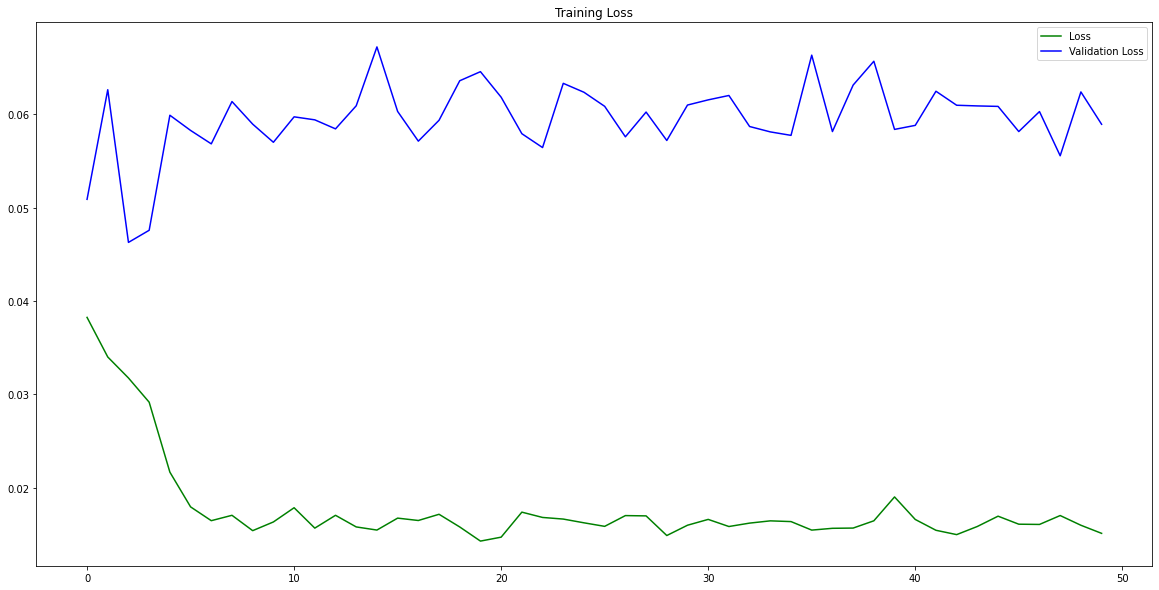

In [34]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(20,10))
plt.plot(loss, color = 'green', label = 'Loss')
plt.plot(val_loss, color = 'blue', label = 'Validation Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

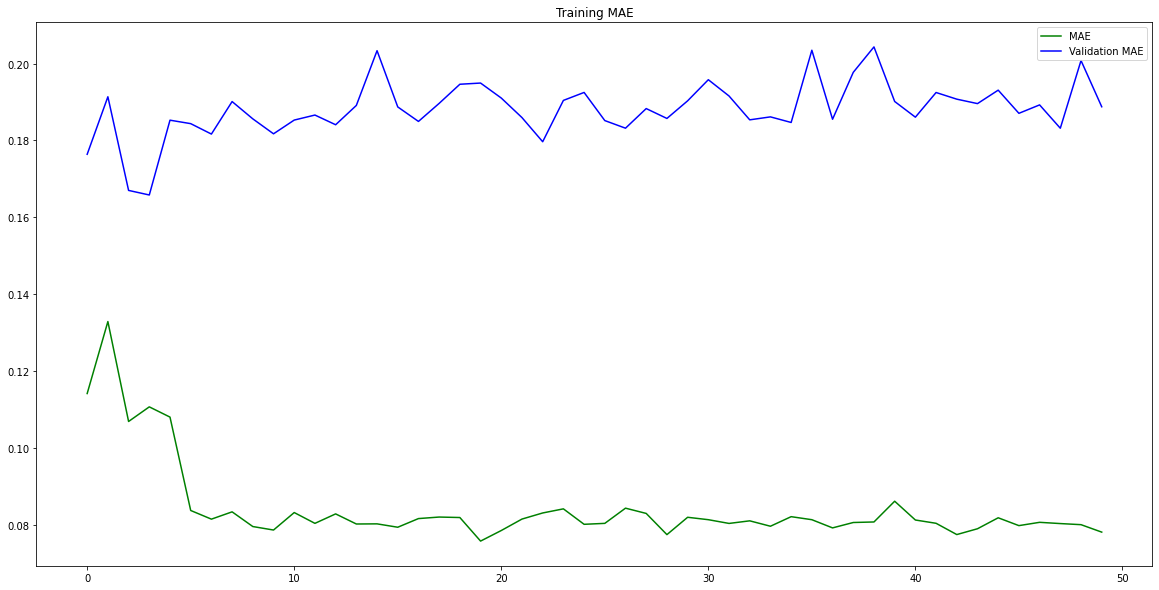

In [35]:
mse = model.history.history['mae']
val_mse = model.history.history['val_mae']

plt.figure(figsize=(20,10))
plt.plot(mse, color = 'green', label = 'MAE')
plt.plot(val_mse, color = 'blue', label = 'Validation MAE')
plt.title('Training MAE')
plt.legend()
plt.show()

## **Model Testing**

In [36]:
predict = model.predict_generator(test_gen_value)

<ipython-input-36-92b2ec09855a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_gen_value)


In [37]:
# Invert prediction
# train_predict = minmax.inverse_transform(train_predict)
# df_train = minmax.inverse_transform(df_train)
predict = minmax.inverse_transform(predict)
test_gen_value = minmax.inverse_transform(test_gen_value)

In [38]:
# test_gen_date

In [39]:
# Train Prediction
# plt.figure(figsize=(20,10))
# plt.plot(df_train, color = 'green', label = 'Actual Carbon Monoxide (CO)')
# plt.plot(train_predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
# plt.title('Carbon Monoxide (CO)')
# plt.xlabel('Day')
# plt.ylabel('CO')
# plt.legend()
# plt.show()

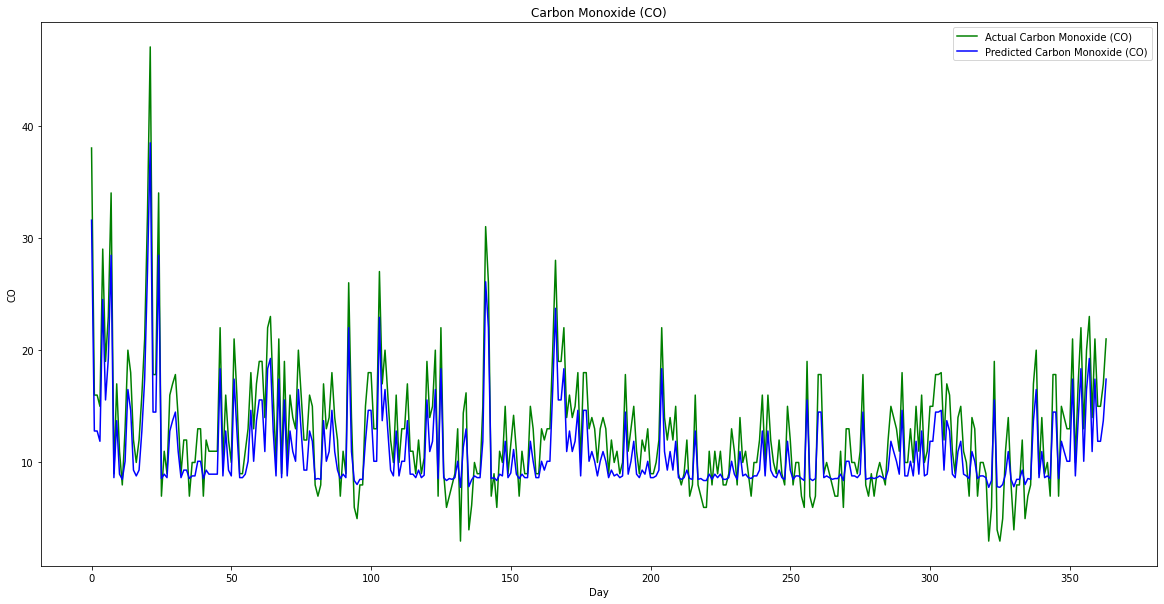

In [40]:
# Test Prediction
plt.figure(figsize=(20,10))
plt.plot(test_gen_value, color = 'green', label = 'Actual Carbon Monoxide (CO)')
plt.plot(predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
plt.title('Carbon Monoxide (CO)')
plt.xlabel('Day')
plt.ylabel('CO')
plt.legend()
plt.show()

## **Model Evaluation**

In [41]:
# close_train = close_train.reshape((-1))
predict = predict.reshape((-1))
test_gen_value = test_gen_value.reshape((-1))

In [42]:
# Calculate RMSE
# trainScore = mean_squared_error(trainY[0], train_predict[0, 0])
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_gen_value, predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 2.64 RMSE


# **5 Years**

## **Read Datasets**

In [43]:
df = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2015-2020.csv')
df['tanggal'] = pd.to_datetime(df.tanggal)
df['tanggal'] = df['tanggal'].dt.strftime('%Y-%m-%d')
df

,tanggal,pm10,so2,co,o3,no2
0,2016-01-01,72.0,32.0,12.0,37.0,11.0
1,2016-01-02,42.0,32.0,8.0,34.0,7.0
2,2016-01-03,37.0,33.0,9.0,48.0,9.0
3,2016-01-04,61.0,33.0,6.0,40.0,20.0
4,2016-01-05,99.0,33.0,24.0,55.0,21.0
...,...,...,...,...,...,...
1822,2020-12-27,30.0,35.0,10.0,44.0,4.0
1823,2020-12-28,29.0,34.0,9.0,31.0,3.0
1824,2020-12-29,21.0,34.0,5.0,20.0,2.0
1825,2020-12-30,26.0,34.0,6.0,15.0,3.0


In [44]:
df_test = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2021.csv')
df_test['tanggal'] = pd.to_datetime(df_test.tanggal)
df_test['tanggal'] = df_test['tanggal'].dt.strftime('%Y-%m-%d')
df_test.head()

,tanggal,pm10,so2,co,o3,no2
0,2021-01-01,41.0,37.0,14.0,35.0,4.0
1,2021-01-02,44.0,38.0,38.0,59.0,3.0
2,2021-01-03,50.0,37.0,16.0,52.0,5.0
3,2021-01-04,45.0,36.0,16.0,24.0,3.0
4,2021-01-05,52.0,36.0,15.0,35.0,8.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  1827 non-null   object 
 1   pm10     1827 non-null   float64
 2   so2      1827 non-null   float64
 3   co       1827 non-null   float64
 4   o3       1827 non-null   float64
 5   no2      1827 non-null   float64
dtypes: float64(5), object(1)
memory usage: 85.8+ KB


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  365 non-null    object 
 1   pm10     365 non-null    float64
 2   so2      365 non-null    float64
 3   co       365 non-null    float64
 4   o3       365 non-null    float64
 5   no2      365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


## **Train Test Split**

In [47]:
size = 1461 # Take 1 year for validation

df_train = df[:size]
df_valid = df[size:]

In [48]:
df_train

,tanggal,pm10,so2,co,o3,no2
0,2016-01-01,72.0,32.0,12.0,37.0,11.0
1,2016-01-02,42.0,32.0,8.0,34.0,7.0
2,2016-01-03,37.0,33.0,9.0,48.0,9.0
3,2016-01-04,61.0,33.0,6.0,40.0,20.0
4,2016-01-05,99.0,33.0,24.0,55.0,21.0
...,...,...,...,...,...,...
1456,2019-12-27,55.0,38.0,17.0,84.0,7.0
1457,2019-12-28,58.0,37.0,21.0,51.0,8.0
1458,2019-12-29,64.0,38.0,17.0,61.0,6.0
1459,2019-12-30,77.0,37.0,26.0,70.0,4.0


In [49]:
df_valid

,tanggal,pm10,so2,co,o3,no2
1461,2020-01-01,33.0,36.0,6.4,36.0,6.0
1462,2020-01-02,45.0,36.0,25.0,46.0,5.0
1463,2020-01-03,51.0,37.0,15.0,46.0,6.0
1464,2020-01-04,48.0,38.0,14.0,51.0,5.0
1465,2020-01-05,40.0,39.0,19.0,50.0,5.0
...,...,...,...,...,...,...
1822,2020-12-27,30.0,35.0,10.0,44.0,4.0
1823,2020-12-28,29.0,34.0,9.0,31.0,3.0
1824,2020-12-29,21.0,34.0,5.0,20.0,2.0
1825,2020-12-30,26.0,34.0,6.0,15.0,3.0


### **Data Training**

In [50]:
date_train = df_train[['tanggal']]
date_train

,tanggal
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05
...,...
1456,2019-12-27
1457,2019-12-28
1458,2019-12-29
1459,2019-12-30


In [51]:
data_train = df_train[['co']]
data_train

,co
0,12.0
1,8.0
2,9.0
3,6.0
4,24.0
...,...
1456,17.0
1457,21.0
1458,17.0
1459,26.0


In [52]:
data_train.shape

(1461, 1)

### **Data Validation**

In [53]:
date_valid = df_valid[['tanggal']]
date_valid

,tanggal
1461,2020-01-01
1462,2020-01-02
1463,2020-01-03
1464,2020-01-04
1465,2020-01-05
...,...
1822,2020-12-27
1823,2020-12-28
1824,2020-12-29
1825,2020-12-30


In [54]:
data_valid = df_valid[['co']]
data_valid

,co
1461,6.4
1462,25.0
1463,15.0
1464,14.0
1465,19.0
...,...
1822,10.0
1823,9.0
1824,5.0
1825,6.0


In [55]:
data_valid.shape

(366, 1)

### **Data Testing**

In [56]:
date_test = df_test[['tanggal']]
date_test.head()

,tanggal
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [57]:
data_test = df_test[['co']]
data_test.head()

,co
0,14.0
1,38.0
2,16.0
3,16.0
4,15.0


In [58]:
data_test.shape

(365, 1)

## **Normalize Data**

In [59]:
minmax = MinMaxScaler(feature_range=(0, 1))
data_train = minmax.fit_transform(data_train)
data_valid = minmax.fit_transform(data_valid)
data_test = minmax.fit_transform(data_test)

## **Input Parameter**

In [60]:
look_back = 1

train_gen = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=30)
valid_gen = TimeseriesGenerator(data_valid, data_valid, length=look_back, batch_size=7)
test_gen = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

In [61]:
print('Samples: {}'.format(len(train_gen)))

Samples: 49


In [62]:
for i in range(len(train_gen)):
	x, y = train_gen[i]
	print('{} => {}'.format(x, y))

[[[0.12676056]]

 [[0.07042254]]

 [[0.08450704]]

 [[0.04225352]]

 [[0.29577465]]

 [[0.08450704]]

 [[0.07042254]]

 [[0.02816901]]

 [[0.07042254]]

 [[0.05633803]]

 [[0.14084507]]

 [[0.28169014]]

 [[0.11267606]]

 [[0.22535211]]

 [[0.26760563]]

 [[0.25352113]]

 [[0.26760563]]

 [[0.23943662]]

 [[0.1971831 ]]

 [[0.1971831 ]]

 [[0.15492958]]

 [[0.16901408]]

 [[0.16901408]]

 [[0.1971831 ]]

 [[0.16901408]]

 [[0.16901408]]

 [[0.1971831 ]]

 [[0.15492958]]

 [[0.14084507]]

 [[0.15492958]]] => [[0.07042254]
 [0.08450704]
 [0.04225352]
 [0.29577465]
 [0.08450704]
 [0.07042254]
 [0.02816901]
 [0.07042254]
 [0.05633803]
 [0.14084507]
 [0.28169014]
 [0.11267606]
 [0.22535211]
 [0.26760563]
 [0.25352113]
 [0.26760563]
 [0.23943662]
 [0.1971831 ]
 [0.1971831 ]
 [0.15492958]
 [0.16901408]
 [0.16901408]
 [0.1971831 ]
 [0.16901408]
 [0.16901408]
 [0.1971831 ]
 [0.15492958]
 [0.14084507]
 [0.15492958]
 [0.26478873]]
[[[0.26478873]]

 [[0.26478873]]

 [[0.21408451]]

 [[0.05633803]]

In [63]:
print('Samples: {}'.format(len(valid_gen)))

Samples: 53


In [64]:
for i in range(len(valid_gen)):
	x, y = valid_gen[i]
	print('{} => {}'.format(x, y))

[[[0.02330097]]

 [[0.2038835 ]]

 [[0.10679612]]

 [[0.09708738]]

 [[0.14563107]]

 [[0.2815534 ]]

 [[0.13592233]]] => [[0.2038835 ]
 [0.10679612]
 [0.09708738]
 [0.14563107]
 [0.2815534 ]
 [0.13592233]
 [0.11650485]]
[[[0.11650485]]

 [[0.26213592]]

 [[0.13592233]]

 [[0.11650485]]

 [[0.15533981]]

 [[0.04854369]]

 [[0.06796117]]] => [[0.26213592]
 [0.13592233]
 [0.11650485]
 [0.15533981]
 [0.04854369]
 [0.06796117]
 [0.06796117]]
[[[0.06796117]]

 [[0.05825243]]

 [[0.32038835]]

 [[0.31067961]]

 [[0.10679612]]

 [[0.65048544]]

 [[0.08737864]]] => [[0.05825243]
 [0.32038835]
 [0.31067961]
 [0.10679612]
 [0.65048544]
 [0.08737864]
 [0.12621359]]
[[[0.12621359]]

 [[0.2038835 ]]

 [[0.15533981]]

 [[0.17475728]]

 [[0.21359223]]

 [[0.24271845]]

 [[0.08737864]]] => [[0.2038835 ]
 [0.15533981]
 [0.17475728]
 [0.21359223]
 [0.24271845]
 [0.08737864]
 [0.31067961]]
[[[0.31067961]]

 [[0.22330097]]

 [[0.09708738]]

 [[0.13592233]]

 [[0.09708738]]

 [[0.11650485]]

 [[0.34951456]

In [65]:
print('Samples: {}'.format(len(test_gen)))

Samples: 364


In [66]:
for i in range(len(test_gen)):
	x, y = test_gen[i]
	print('{} => {}'.format(x, y))

[[[0.25]]] => [[0.79545455]]
[[[0.79545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.27272727]]
[[[0.27272727]]] => [[0.59090909]]
[[[0.59090909]]] => [[0.36363636]]
[[[0.36363636]]] => [[0.45454545]]
[[[0.45454545]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.31818182]]
[[[0.31818182]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.11363636]]
[[[0.11363636]]] => [[0.22727273]]
[[[0.22727273]]] => [[0.38636364]]
[[[0.38636364]]] => [[0.34090909]]
[[[0.34090909]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.15909091]]
[[[0.15909091]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.40909091]]
[[[0.40909091]]] => [[0.65909091]]
[[[0.65909091]]] => [[1.]]
[[[1.]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.09090909]]
[[[0.09090909]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.29545455]]
[[[0.295454

In [67]:
test_gen_date = date_test[look_back:]
test_gen_value

array([38.        , 16.        , 16.        , 15.        , 29.        ,
       19.        , 23.        , 34.        ,  9.        , 17.        ,
       11.        ,  8.        , 13.        , 20.        , 18.        ,
       12.        , 10.        , 12.        , 16.        , 21.        ,
       32.        , 47.        , 17.82960596, 17.82960596, 34.        ,
        7.        , 11.        ,  9.        , 16.        , 17.        ,
       17.82960596, 14.        ,  9.        , 12.        , 12.        ,
        7.        , 10.        , 10.        , 13.        , 13.        ,
        7.        , 12.        , 11.        , 11.        , 11.        ,
       11.        , 22.        , 10.        , 16.        , 12.        ,
       10.        , 21.        , 16.        ,  9.        ,  9.        ,
       11.        , 13.        , 18.        , 13.        , 17.        ,
       19.        , 19.        , 14.        , 22.        , 23.        ,
       16.        , 10.        , 21.        ,  9.        , 19.  

In [68]:
test_gen_value = data_test[look_back:]
test_gen_value

array([[0.79545455],
       [0.29545455],
       [0.29545455],
       [0.27272727],
       [0.59090909],
       [0.36363636],
       [0.45454545],
       [0.70454545],
       [0.13636364],
       [0.31818182],
       [0.18181818],
       [0.11363636],
       [0.22727273],
       [0.38636364],
       [0.34090909],
       [0.20454545],
       [0.15909091],
       [0.20454545],
       [0.29545455],
       [0.40909091],
       [0.65909091],
       [1.        ],
       [0.3370365 ],
       [0.3370365 ],
       [0.70454545],
       [0.09090909],
       [0.18181818],
       [0.13636364],
       [0.29545455],
       [0.31818182],
       [0.3370365 ],
       [0.25      ],
       [0.13636364],
       [0.20454545],
       [0.20454545],
       [0.09090909],
       [0.15909091],
       [0.15909091],
       [0.22727273],
       [0.22727273],
       [0.09090909],
       [0.20454545],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.43181818],
       [0.159

## **Initialize Model Parameter**

In [69]:
# create and fit the LSTM network
model = tf.keras.Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 32, return_sequences = True, input_shape = (look_back, 1)))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 128))
model.add(tf.keras.layers.Dropout(0.2))
# Adding hidden layers
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# Adding the output layer
model.add(tf.keras.layers.Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_3 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             24832     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 30)               

## **Model Training**

In [70]:
# Compiling the RNN
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['mae'])

# Fitting the RNN to the Training set
model.fit(train_gen, validation_data=valid_gen, epochs = 50, verbose=1)

Epoch 1/50
49/49 [==============================] - 5s 33ms/step - loss: 0.0194 - mae: 0.1017 - val_loss: 0.0316 - val_mae: 0.1168
Epoch 2/50
49/49 [==============================] - 0s 10ms/step - loss: 0.0138 - mae: 0.0879 - val_loss: 0.0305 - val_mae: 0.1113
Epoch 3/50
49/49 [==============================] - 1s 10ms/step - loss: 0.0132 - mae: 0.0865 - val_loss: 0.0264 - val_mae: 0.1052
Epoch 4/50
49/49 [==============================] - 0s 10ms/step - loss: 0.0127 - mae: 0.0834 - val_loss: 0.0241 - val_mae: 0.1097
Epoch 5/50
49/49 [==============================] - 1s 10ms/step - loss: 0.0124 - mae: 0.0839 - val_loss: 0.0207 - val_mae: 0.1118
Epoch 6/50
49/49 [==============================] - 0s 10ms/step - loss: 0.0119 - mae: 0.0812 - val_loss: 0.0203 - val_mae: 0.0900
Epoch 7/50
49/49 [==============================] - 1s 10ms/step - loss: 0.0118 - mae: 0.0806 - val_loss: 0.0189 - val_mae: 0.0923
Epoch 8/50
49/49 [==============================] - 0s 10ms/step - loss: 0.0117 - m

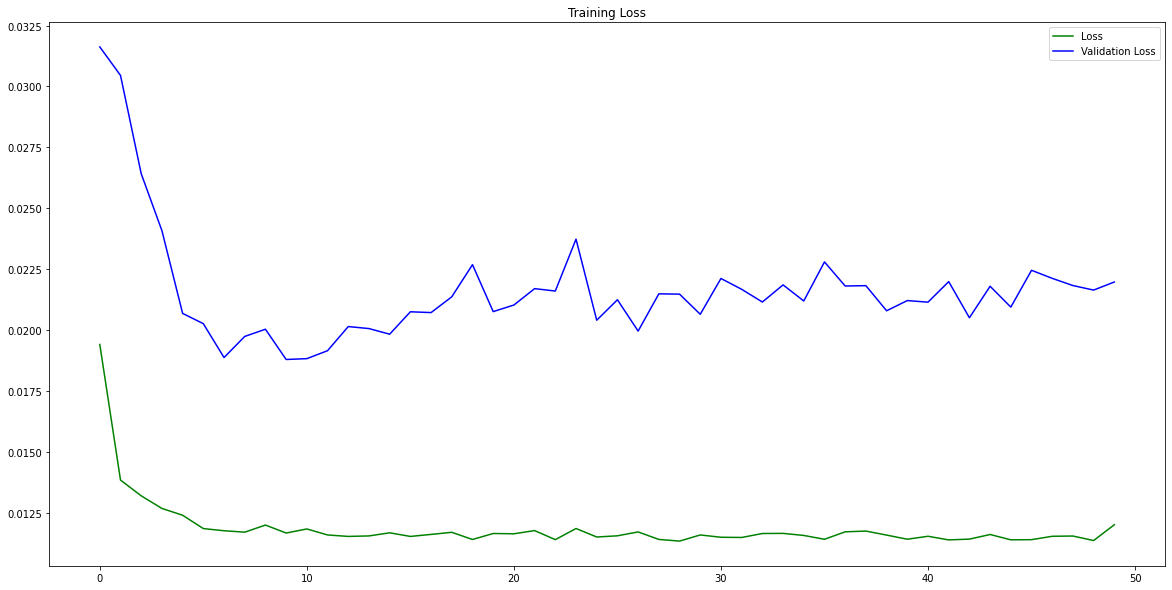

In [71]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(20,10))
plt.plot(loss, color = 'green', label = 'Loss')
plt.plot(val_loss, color = 'blue', label = 'Validation Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

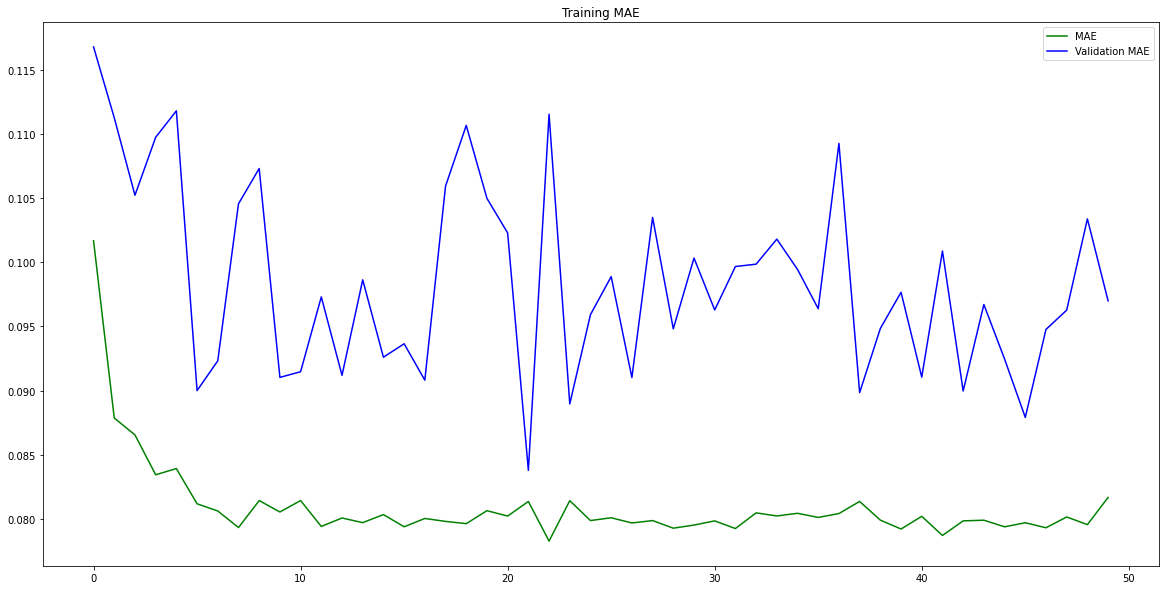

In [72]:
mse = model.history.history['mae']
val_mse = model.history.history['val_mae']

plt.figure(figsize=(20,10))
plt.plot(mse, color = 'green', label = 'MAE')
plt.plot(val_mse, color = 'blue', label = 'Validation MAE')
plt.title('Training MAE')
plt.legend()
plt.show()

## **Model Testing**

In [73]:
predict = model.predict_generator(test_gen_value)

<ipython-input-73-92b2ec09855a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_gen_value)


In [74]:
# Invert prediction
# train_predict = minmax.inverse_transform(train_predict)
# df_train = minmax.inverse_transform(df_train)
predict = minmax.inverse_transform(predict)
test_gen_value = minmax.inverse_transform(test_gen_value)

In [75]:
# Train Prediction
# plt.figure(figsize=(20,10))
# plt.plot(df_train, color = 'green', label = 'Actual Carbon Monoxide (CO)')
# plt.plot(train_predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
# plt.title('Carbon Monoxide (CO)')
# plt.xlabel('Day')
# plt.ylabel('CO')
# plt.legend()
# plt.show()

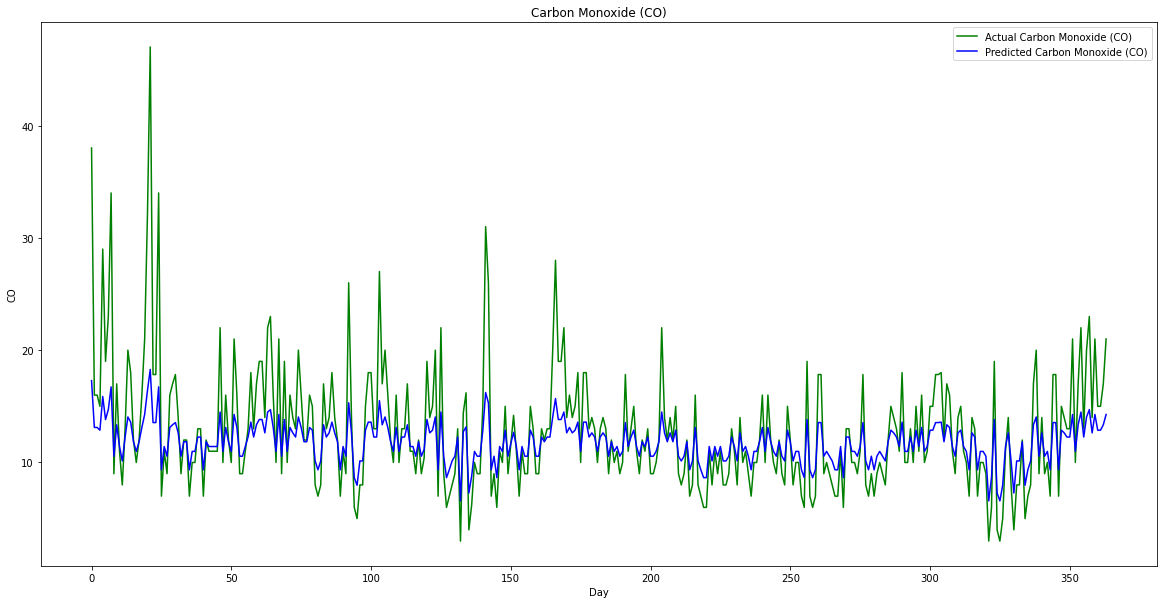

In [76]:
# Test Prediction
plt.figure(figsize=(20,10))
plt.plot(test_gen_value, color = 'green', label = 'Actual Carbon Monoxide (CO)')
plt.plot(predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
plt.title('Carbon Monoxide (CO)')
plt.xlabel('Day')
plt.ylabel('CO')
plt.legend()
plt.show()

## **Model Evaluation**

In [77]:
# close_train = close_train.reshape((-1))
predict = predict.reshape((-1))
test_gen_value = test_gen_value.reshape((-1))

In [78]:
# Calculate RMSE
# trainScore = mean_squared_error(trainY[0], train_predict[0, 0])
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_gen_value, predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.95 RMSE


# **10 Years**

## **Read Dataset**

In [79]:
df = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2011-2020.csv')
df['tanggal'] = pd.to_datetime(df.tanggal)
df['tanggal'] = df['tanggal'].dt.strftime('%Y-%m-%d')
df

,tanggal,pm10,so2,co,o3,no2
0,2011-01-01,41.6,2.0,14.0,47.0,5.0
1,2011-01-02,43.0,3.0,10.0,36.0,5.0
2,2011-01-03,55.0,2.0,35.0,18.0,11.0
3,2011-01-04,53.0,18.8,12.0,46.0,10.4
4,2011-01-05,59.0,22.8,14.6,38.0,12.6
...,...,...,...,...,...,...
3648,2020-12-27,30.0,35.0,10.0,44.0,4.0
3649,2020-12-28,29.0,34.0,9.0,31.0,3.0
3650,2020-12-29,21.0,34.0,5.0,20.0,2.0
3651,2020-12-30,26.0,34.0,6.0,15.0,3.0


In [80]:
df_test = pd.read_csv('/content/air-pollution-forecasting/datasets/research/jkt-timur-ispu-2021.csv')
df_test['tanggal'] = pd.to_datetime(df_test.tanggal)
df_test['tanggal'] = df_test['tanggal'].dt.strftime('%Y-%m-%d')
df_test

,tanggal,pm10,so2,co,o3,no2
0,2021-01-01,41.0,37.0,14.0,35.0,4.0
1,2021-01-02,44.0,38.0,38.0,59.0,3.0
2,2021-01-03,50.0,37.0,16.0,52.0,5.0
3,2021-01-04,45.0,36.0,16.0,24.0,3.0
4,2021-01-05,52.0,36.0,15.0,35.0,8.0
...,...,...,...,...,...,...
360,2021-12-27,68.0,17.0,21.0,67.4,12.0
361,2021-12-28,59.0,38.0,15.0,24.8,22.0
362,2021-12-29,61.0,37.0,15.0,38.6,19.0
363,2021-12-30,60.0,38.0,17.0,24.2,21.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  3653 non-null   object 
 1   pm10     3653 non-null   float64
 2   so2      3653 non-null   float64
 3   co       3653 non-null   float64
 4   o3       3653 non-null   float64
 5   no2      3653 non-null   float64
dtypes: float64(5), object(1)
memory usage: 171.4+ KB


In [82]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  365 non-null    object 
 1   pm10     365 non-null    float64
 2   so2      365 non-null    float64
 3   co       365 non-null    float64
 4   o3       365 non-null    float64
 5   no2      365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


## **Train Test Split**

In [83]:
size = 2921 # Take 2 year for validation

df_train = df[:size]
df_valid = df[size:]

In [84]:
df_train

,tanggal,pm10,so2,co,o3,no2
0,2011-01-01,41.6,2.0,14.0,47.0,5.0
1,2011-01-02,43.0,3.0,10.0,36.0,5.0
2,2011-01-03,55.0,2.0,35.0,18.0,11.0
3,2011-01-04,53.0,18.8,12.0,46.0,10.4
4,2011-01-05,59.0,22.8,14.6,38.0,12.6
...,...,...,...,...,...,...
2916,2018-12-26,31.0,25.0,5.0,22.0,3.0
2917,2018-12-27,28.0,25.0,7.0,30.0,6.0
2918,2018-12-28,25.0,24.0,4.0,23.0,3.0
2919,2018-12-29,30.0,24.0,4.0,21.0,2.0


In [85]:
df_valid

,tanggal,pm10,so2,co,o3,no2
2921,2018-12-31,33.0,8.0,6.0,20.0,4.0
2922,2019-01-01,16.0,7.0,6.0,24.0,3.0
2923,2019-01-02,17.0,7.0,5.0,25.0,4.0
2924,2019-01-03,15.0,7.0,5.0,26.0,4.0
2925,2019-01-04,32.0,8.0,9.0,48.0,8.0
...,...,...,...,...,...,...
3648,2020-12-27,30.0,35.0,10.0,44.0,4.0
3649,2020-12-28,29.0,34.0,9.0,31.0,3.0
3650,2020-12-29,21.0,34.0,5.0,20.0,2.0
3651,2020-12-30,26.0,34.0,6.0,15.0,3.0


### **Data Training**

In [86]:
date_train = df_train[['tanggal']]
date_train

,tanggal
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05
...,...
2916,2018-12-26
2917,2018-12-27
2918,2018-12-28
2919,2018-12-29


In [87]:
data_train = df_train[['co']]
data_train

,co
0,14.0
1,10.0
2,35.0
3,12.0
4,14.6
...,...
2916,5.0
2917,7.0
2918,4.0
2919,4.0


In [88]:
data_train.shape

(2921, 1)

### **Data Validation**

In [89]:
date_valid = df_valid[['tanggal']]
date_valid

,tanggal
2921,2018-12-31
2922,2019-01-01
2923,2019-01-02
2924,2019-01-03
2925,2019-01-04
...,...
3648,2020-12-27
3649,2020-12-28
3650,2020-12-29
3651,2020-12-30


In [90]:
data_valid = df_valid[['co']]
data_valid

,co
2921,6.0
2922,6.0
2923,5.0
2924,5.0
2925,9.0
...,...
3648,10.0
3649,9.0
3650,5.0
3651,6.0


In [91]:
data_valid.shape

(732, 1)

### **Data Testing**

In [92]:
date_test = df_test[['tanggal']]
date_test.head()

,tanggal
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [93]:
data_test = df_test[['co']]
data_test.head()

,co
0,14.0
1,38.0
2,16.0
3,16.0
4,15.0


In [94]:
data_test.shape

(365, 1)

## **Normalize Data**

In [95]:
minmax = MinMaxScaler(feature_range=(0, 1))
data_train = minmax.fit_transform(data_train)
data_valid = minmax.fit_transform(data_valid)
data_test = minmax.fit_transform(data_test)

## **Input Parameter**

In [96]:
look_back = 1

train_gen = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=30)
valid_gen = TimeseriesGenerator(data_valid, data_valid, length=look_back, batch_size=7)
test_gen = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

In [97]:
print('Samples: {}'.format(len(train_gen)))

Samples: 98


In [98]:
for i in range(len(train_gen)):
	x, y = train_gen[i]
	print('{} => {}'.format(x, y))

[[[0.10447761]]

 [[0.07462687]]

 [[0.26119403]]

 [[0.08955224]]

 [[0.10895522]]

 [[0.11791045]]

 [[0.08955224]]

 [[0.2761194 ]]

 [[0.23134328]]

 [[0.05970149]]

 [[0.10447761]]

 [[0.10447761]]

 [[0.17910448]]

 [[0.08208955]]

 [[0.13305676]]

 [[0.08208955]]

 [[0.13432836]]

 [[0.13305676]]

 [[0.41044776]]

 [[0.19402985]]

 [[0.32089552]]

 [[0.29104478]]

 [[0.44029851]]

 [[0.23880597]]

 [[0.18656716]]

 [[0.14925373]]

 [[0.19402985]]

 [[0.28358209]]

 [[0.08955224]]

 [[0.1119403 ]]] => [[0.07462687]
 [0.26119403]
 [0.08955224]
 [0.10895522]
 [0.11791045]
 [0.08955224]
 [0.2761194 ]
 [0.23134328]
 [0.05970149]
 [0.10447761]
 [0.10447761]
 [0.17910448]
 [0.08208955]
 [0.13305676]
 [0.08208955]
 [0.13432836]
 [0.13305676]
 [0.41044776]
 [0.19402985]
 [0.32089552]
 [0.29104478]
 [0.44029851]
 [0.23880597]
 [0.18656716]
 [0.14925373]
 [0.19402985]
 [0.28358209]
 [0.08955224]
 [0.1119403 ]
 [0.07462687]]
[[[0.07462687]]

 [[0.13432836]]

 [[0.17164179]]

 [[0.14925373]]

In [99]:
print('Samples: {}'.format(len(test_gen)))

Samples: 364


In [100]:
for i in range(len(test_gen)):
	x, y = test_gen[i]
	print('{} => {}'.format(x, y))

[[[0.25]]] => [[0.79545455]]
[[[0.79545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.27272727]]
[[[0.27272727]]] => [[0.59090909]]
[[[0.59090909]]] => [[0.36363636]]
[[[0.36363636]]] => [[0.45454545]]
[[[0.45454545]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.31818182]]
[[[0.31818182]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.11363636]]
[[[0.11363636]]] => [[0.22727273]]
[[[0.22727273]]] => [[0.38636364]]
[[[0.38636364]]] => [[0.34090909]]
[[[0.34090909]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.15909091]]
[[[0.15909091]]] => [[0.20454545]]
[[[0.20454545]]] => [[0.29545455]]
[[[0.29545455]]] => [[0.40909091]]
[[[0.40909091]]] => [[0.65909091]]
[[[0.65909091]]] => [[1.]]
[[[1.]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.3370365]]
[[[0.3370365]]] => [[0.70454545]]
[[[0.70454545]]] => [[0.09090909]]
[[[0.09090909]]] => [[0.18181818]]
[[[0.18181818]]] => [[0.13636364]]
[[[0.13636364]]] => [[0.29545455]]
[[[0.295454

In [101]:
test_gen_value = data_test[look_back:]
test_gen_value

array([[0.79545455],
       [0.29545455],
       [0.29545455],
       [0.27272727],
       [0.59090909],
       [0.36363636],
       [0.45454545],
       [0.70454545],
       [0.13636364],
       [0.31818182],
       [0.18181818],
       [0.11363636],
       [0.22727273],
       [0.38636364],
       [0.34090909],
       [0.20454545],
       [0.15909091],
       [0.20454545],
       [0.29545455],
       [0.40909091],
       [0.65909091],
       [1.        ],
       [0.3370365 ],
       [0.3370365 ],
       [0.70454545],
       [0.09090909],
       [0.18181818],
       [0.13636364],
       [0.29545455],
       [0.31818182],
       [0.3370365 ],
       [0.25      ],
       [0.13636364],
       [0.20454545],
       [0.20454545],
       [0.09090909],
       [0.15909091],
       [0.15909091],
       [0.22727273],
       [0.22727273],
       [0.09090909],
       [0.20454545],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.18181818],
       [0.43181818],
       [0.159

## **Initialize Model Parameter**

In [102]:
# create and fit the LSTM network
model = tf.keras.Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 32, return_sequences = True, input_shape = (look_back, 1)))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(tf.keras.layers.LSTM(units = 128))
model.add(tf.keras.layers.Dropout(0.2))
# Adding the output layer
model.add(tf.keras.layers.Dense(units = 1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 32)             4352      
                                                                 
 dropout_6 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 64)             24832     
                                                                 
 dropout_7 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

## **Model Training**

In [103]:
# Compiling the RNN
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['mae'])

# Fitting the RNN to the Training set
model.fit(train_gen, validation_data=valid_gen, batch_size=16, epochs = 50, verbose=1)

Epoch 1/50
98/98 [==============================] - 5s 19ms/step - loss: 0.0098 - mae: 0.0701 - val_loss: 0.0180 - val_mae: 0.0822
Epoch 2/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0074 - mae: 0.0625 - val_loss: 0.0153 - val_mae: 0.0753
Epoch 3/50
98/98 [==============================] - 1s 13ms/step - loss: 0.0065 - mae: 0.0567 - val_loss: 0.0113 - val_mae: 0.0688
Epoch 4/50
98/98 [==============================] - 1s 13ms/step - loss: 0.0059 - mae: 0.0529 - val_loss: 0.0105 - val_mae: 0.0738
Epoch 5/50
98/98 [==============================] - 1s 9ms/step - loss: 0.0058 - mae: 0.0525 - val_loss: 0.0108 - val_mae: 0.0642
Epoch 6/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0058 - mae: 0.0520 - val_loss: 0.0104 - val_mae: 0.0664
Epoch 7/50
98/98 [==============================] - 1s 10ms/step - loss: 0.0058 - mae: 0.0525 - val_loss: 0.0106 - val_mae: 0.0654
Epoch 8/50
98/98 [==============================] - 1s 9ms/step - loss: 0.0058 - mae

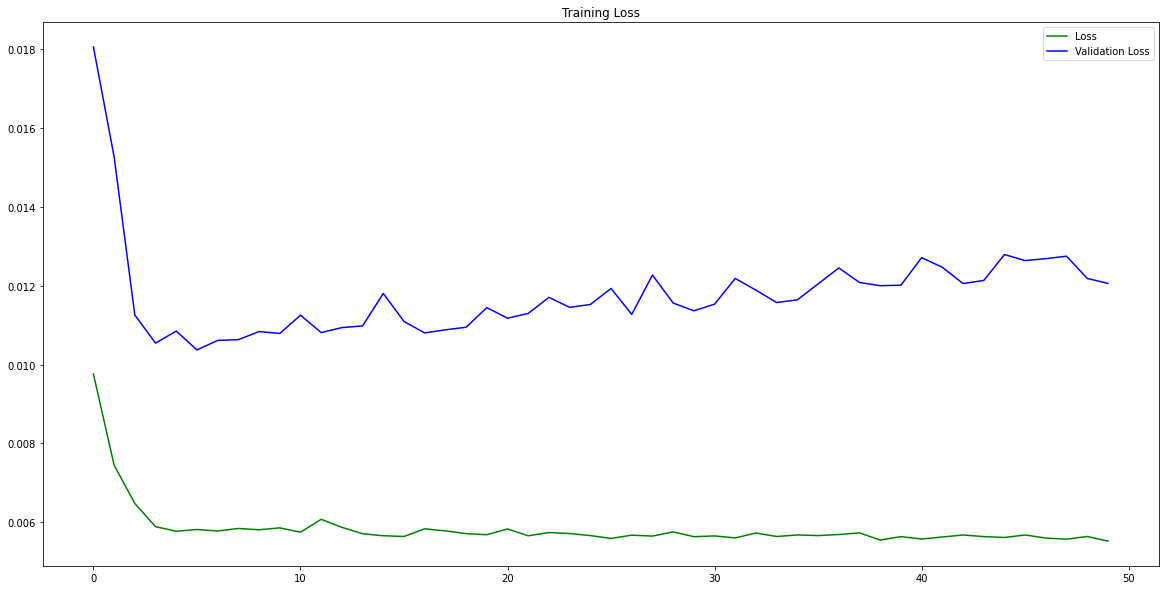

In [104]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(20,10))
plt.plot(loss, color = 'green', label = 'Loss')
plt.plot(val_loss, color = 'blue', label = 'Validation Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

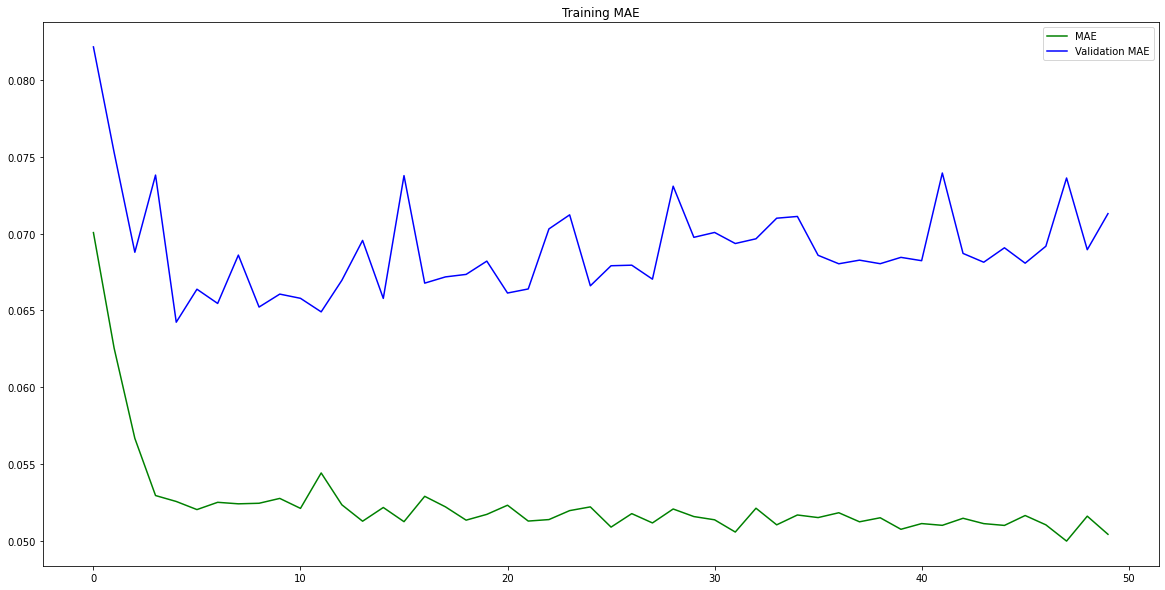

In [105]:
mse = model.history.history['mae']
val_mse = model.history.history['val_mae']

plt.figure(figsize=(20,10))
plt.plot(mse, color = 'green', label = 'MAE')
plt.plot(val_mse, color = 'blue', label = 'Validation MAE')
plt.title('Training MAE')
plt.legend()
plt.show()

## **Model Testing**

In [106]:
predict = model.predict_generator(test_gen_value)

<ipython-input-106-92b2ec09855a>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_gen_value)


In [107]:
# Invert prediction
# train_predict = minmax.inverse_transform(train_predict)
# df_train = minmax.inverse_transform(df_train)
predict = minmax.inverse_transform(predict)
test_gen_value = minmax.inverse_transform(test_gen_value)

In [108]:
# Train Prediction
# plt.figure(figsize=(20,10))
# plt.plot(df_train, color = 'green', label = 'Actual Carbon Monoxide (CO)')
# plt.plot(train_predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
# plt.title('Carbon Monoxide (CO)')
# plt.xlabel('Day')
# plt.ylabel('CO')
# plt.legend()
# plt.show()

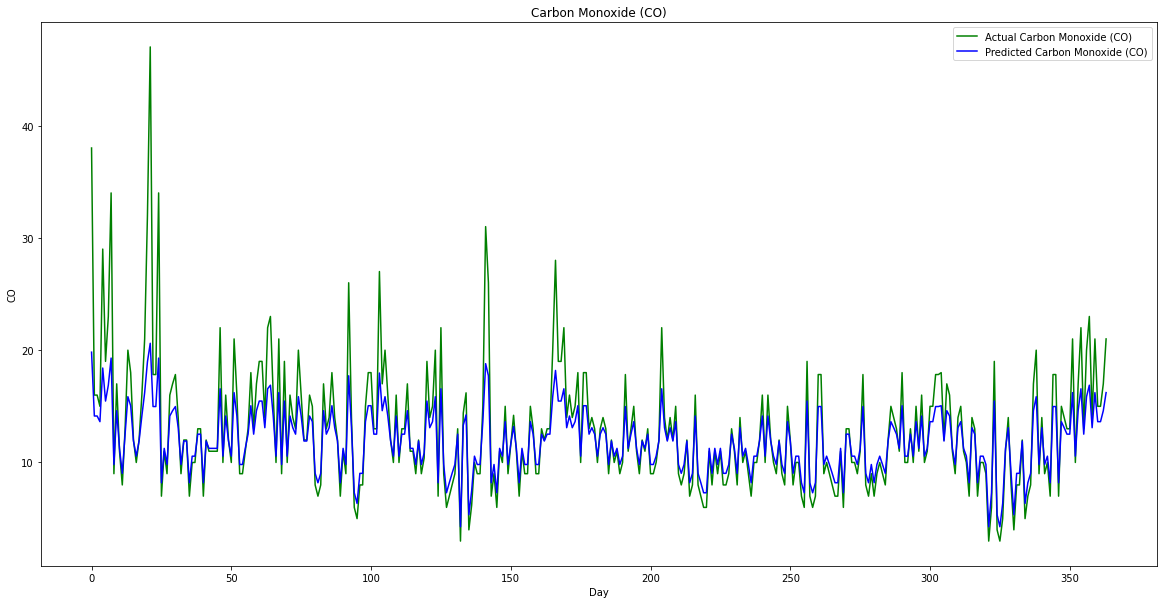

In [109]:
# Test Prediction
plt.figure(figsize=(20,10))
plt.plot(test_gen_value, color = 'green', label = 'Actual Carbon Monoxide (CO)')
plt.plot(predict, color = 'blue', label = 'Predicted Carbon Monoxide (CO)')
plt.title('Carbon Monoxide (CO)')
plt.xlabel('Day')
plt.ylabel('CO')
plt.legend()
plt.show()

## **Model Evaluation**

In [110]:
# close_train = close_train.reshape((-1))
predict = predict.reshape((-1))
test_gen_value = test_gen_value.reshape((-1))

In [111]:
# Calculate RMSE
# trainScore = mean_squared_error(trainY[0], train_predict[0, 0])
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_gen_value, predict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.04 RMSE
